Estimated linear fit: f(delta_cond) = a*conc with
 a = 0.000818±2.8e-5

Estimated linear fit: f(delta_cond) = a*conc with
 a = 0.000812±9.9e-5

Estimated linear fit: f(delta_cond) = a*conc with
 a = 0.000456±5.18e-6

958: 9.700806565484955 sd: 9.842223520028694 530: 8.798080978404498 delta_calib_958: 0.1414169545437396 delta_delta_calib_530: 1.044142541624197 delta_calib_554: 0.006539618492093169

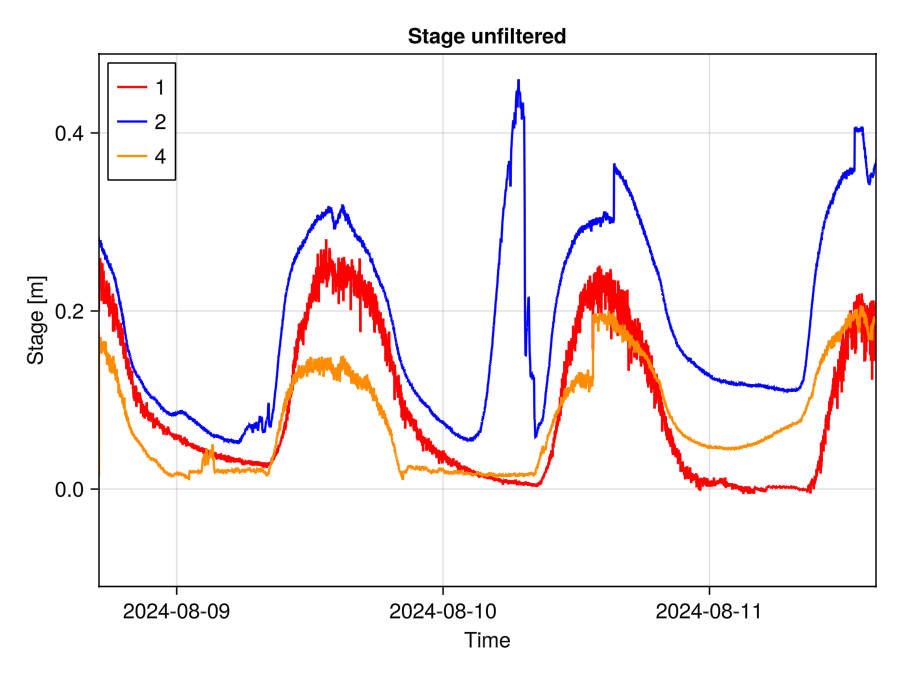

[ Info: Unsafe comparisons using the function `pmean` has been enabled globally. Use `@unsafe` to enable in a local expression only or `unsafe_comparisons(false)` to turn off unsafe comparisons


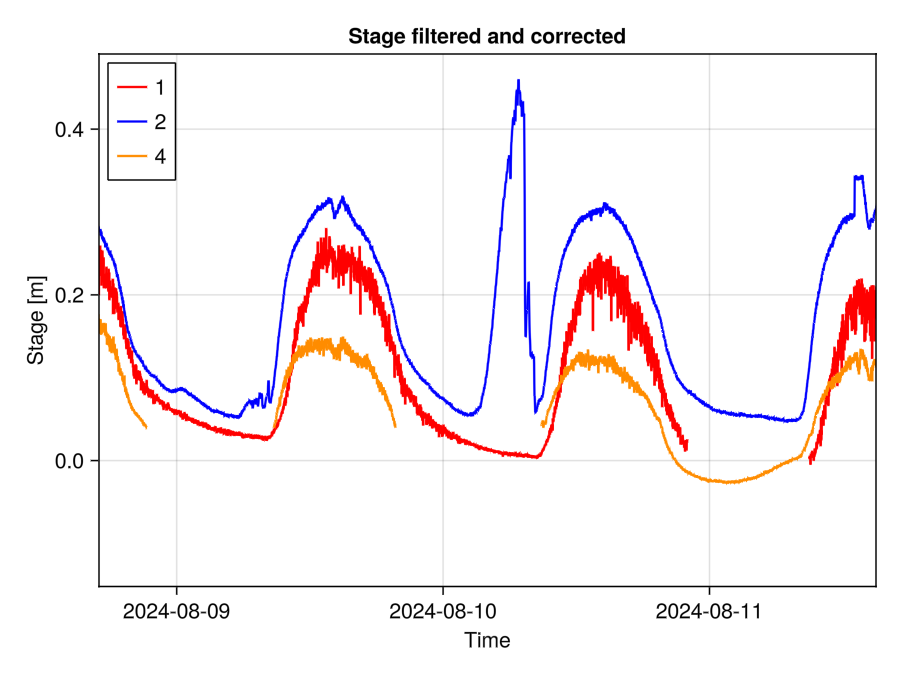

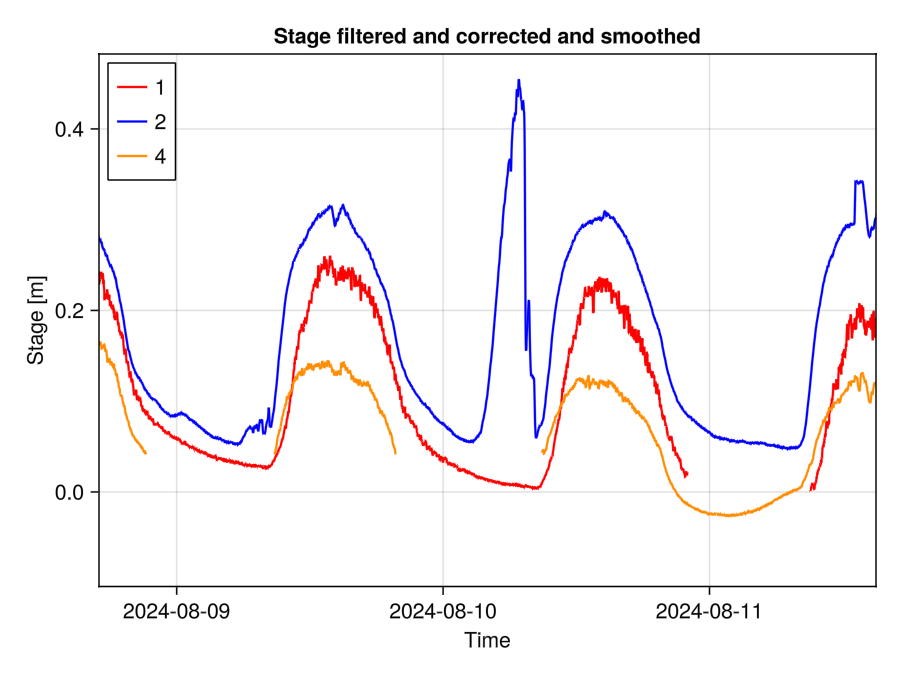

Estimated linear fit sensor 530: Q(s) = a + b*stage with
 a = -0.173 ± 0.05, b = 1.33 ± 0.23

Estimated linear fit sensor 554: Q(s) = a + b*stage with
 a = 0.0524 ± 0.028, b = 2.89 ± 0.25

Estimated linear fit sensor 958: Q(s) = a + b*stage with
 a = 3.57 ± 2.8, b = -26.2 ± 22.0



LoadError: LoadError: KeyError: key :q not found
in expression starting at C:\Users\herol\julia\GlacierHydroFieldcourse.jl\notebooks\5_further_work-uncertainties.ipynb:In[48]:1

In [1]:
using CSV, DataFrames, NamedArrays
using Plots #, GLMakie
using MonteCarloMeasurements, Distributions, Statistics, GLM
using NBInclude
@nbinclude("5_further_work-uncertainties.ipynb")

## Reading in the data and assigning uncertainties to the values

In [2]:
poly = CSV.read("../data/raw/GISData_raw.csv", DataFrame)
poly.Area = poly.Area ± 0.1.*poly.Area
poly.Perimeter = poly.Perimeter ± 0.02.*poly.Perimeter
poly.MaxDist = poly.MaxDist .± 0.5
poly.Stream = floor.(Int, poly.id)
poly.Section = round.((poly.id .- poly.Stream).*10)
poly.Section = Int.(poly.Section) #different from section of StreamSurvey!!
poly

15×7 DataFrame
 Row │ id       Name          Area          Perimeter     MaxDist      Stream  ⋯
     │ Float64  String15      Particle…     Particle…     Particle…    Int64   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     1.0  01InjCTD      217.0 ± 22.0  270.0 ± 5.5   124.0 ± 0.5       1  ⋯
   2 │     1.1  01InjWTW       91.8 ± 9.6   132.0 ± 2.6    63.7 ± 0.5       1
   3 │     1.2  01WTWCTD      125.0 ± 12.0  141.0 ± 2.7    63.2 ± 0.5       1
   4 │     2.0  02InjCTD      306.0 ± 31.0  649.0 ± 13.0  289.0 ± 0.5       2
   5 │     2.1  02InjWTW      193.0 ± 19.0  451.0 ± 9.0   207.0 ± 0.5       2  ⋯
   6 │     2.2  02WTWCTD      114.0 ± 11.0  200.0 ± 4.0    83.5 ± 0.5       2
   7 │     3.0  03InjCTD      129.0 ± 13.0  255.0 ± 5.2   120.0 ± 0.5       3
   8 │     3.1  03InjWTW       57.9 ± 5.6   115.0 ± 2.3    52.7 ± 0.5       3
   9 │     3.2  03WTWCTD       71.3 ± 7.2   143.0 ± 2.9    67.6 ± 0.5       3  ⋯
  10 │     4.0  04InjCTD      141.0 ± 14.0  244.0 ± 4.8    98.4 ± 0.5       4
  11 │     4.1  04InjWTW       34.3 ± 3.4    58.7 ± 1.2    24.6 ± 0.5       4
  12 │     4.2  04WTWCTD      106.0 ± 11.0  188.0 ± 3.7    75.0 ± 0.5       4
  13 │     5.0  1upperInjCTD   75.8 ± 7.6   171.0 ± 3.3    76.3 ± 0.5       5  ⋯
  14 │     5.1  1upperInjWTW   56.0 ± 5.6   116.0 ± 2.4    52.2 ± 0.5       5
  15 │     5.2  1upperWTWCTD   19.9 ± 2.0    56.2 ± 1.1    26.8 ± 0.5       5
                                                                1 column omitted

In [3]:
StreamSurvey_full = CSV.read("../data/raw/streams_corr.csv", DataFrame) #streamsection: 0 -> above Inj, 1 -> Inj, 2 -> Inj-WTW 3 -> WTW, 4 -> WTW-CTD, 5 -> CTD, 6 -> below CTD
StreamSurvey = StreamSurvey_full[:, ["Stream", "StreamSection", "Order", "Ellh_corr", "Width", "Depth1", "Depth2", "Depth3"]]
StreamSurvey.Ellh_corr = StreamSurvey.Ellh_corr .± StreamSurvey_full."Elevation RMS"
StreamSurvey.Width = StreamSurvey.Width ± 0.05 
StreamSurvey.Depth1 = StreamSurvey.Depth1 ± 0.02
StreamSurvey.Depth2 = StreamSurvey.Depth2 ± 0.02
StreamSurvey.Depth3 = StreamSurvey.Depth3 ± 0.02

StreamSurvey.Width = StreamSurvey.Width ./ 100 #everything in [m]
StreamSurvey.Depth1 = StreamSurvey.Depth1 ./ 100
StreamSurvey.Depth2 = StreamSurvey.Depth2 ./ 100
StreamSurvey.Depth3 = StreamSurvey.Depth3 ./ 100
StreamSurvey

45×8 DataFrame
 Row │ Stream  StreamSection  Order  Ellh_corr       Width           Depth1    ⋯
     │ Int64   Int64          Int64  Particle…       Particle…       Particle… ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │      2              1      1  2710.0 ± 0.015  0.7 ± 0.0005    0.25 ± 0. ⋯
   2 │      2              2      2  2710.0 ± 0.012  1.1 ± 0.0005    0.2 ± 0.0
   3 │      2              3      3  2710.0 ± 0.019  1.1 ± 0.00048   0.15 ± 0.
   4 │      2              4      3  2710.0 ± 0.01   1.1 ± 0.00051   0.15 ± 0.
   5 │      2              4      4  2710.0 ± 0.012  0.8 ± 0.00049   0.2 ± 0.0 ⋯
   6 │      2              4      5  2710.0 ± 0.016  1.4 ± 0.00051   0.27 ± 0.
   7 │      2              4      6  2710.0 ± 0.014  0.8 ± 0.00051   0.2 ± 0.0
   8 │      2              5      7  2710.0 ± 0.019  1.0 ± 0.00049   0.3 ± 0.0
   9 │      3              0      1  2710.0 ± 0.023  1.45 ± 0.0005   0.23 ± 0. ⋯
  10 │      3              1      2  2710.0 ± 0.022  1.05 ± 0.00049  0.26 ± 0.
  11 │      3              2      3  2710.0 ± 0.016  0.8 ± 0.0005    0.23 ± 0.
  ⋮  │   ⋮           ⋮          ⋮          ⋮               ⋮               ⋮   ⋱
  36 │      1              6     10  2700.0 ± 0.018  1.7 ± 0.0005    0.5 ± 0.0
  37 │      5              0      1  2720.0 ± 0.017  0.7 ± 0.00051   0.25 ± 0. ⋯
  38 │      5              0      2  2720.0 ± 0.02   0.8 ± 0.00051   0.2 ± 0.0
  39 │      5              0      3  2720.0 ± 0.019  0.99 ± 0.00051  0.34 ± 0.
  40 │      5              1      4  2720.0 ± 0.017  0.65 ± 0.00048  0.33 ± 0.
  41 │      5              2      5  2710.0 ± 0.014  0.55 ± 0.0005   0.18 ± 0. ⋯
  42 │      5              2      6  2710.0 ± 0.014  0.7 ± 0.00049   0.23 ± 0.
  43 │      5              3      7  2710.0 ± 0.019  1.05 ± 0.00049  0.33 ± 0.
  44 │      5              4      8  2710.0 ± 0.012  0.65 ± 0.00051  0.25 ± 0.
  45 │      5              5      9  2710.0 ± 0.013  0.75 ± 0.00051  0.2 ± 0.0 ⋯
                                                   3 columns and 24 rows omitted

In [4]:
#traces from 5_...uncertainties
traces.t_WTWCTD = traces.t2 .- traces.t1
rename!(traces, :t1 => :t_InjWTW)
rename!(traces, :t2 => :t_InjCTD)

10×7 DataFrame
 Row │ loc    t_inj                Q1                      Q2              t_I ⋯
     │ Int64  DateTime             Particle…               Particle…       Par ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     1  2024-08-09T11:41:00          0.47 ± 0.047    0.59 ± 0.059        ⋯
   2 │     1  2024-08-09T16:25:06          0.61 ± 0.061    0.77 ± 0.077
   3 │     1  2024-08-11T09:18:35          0.065 ± 0.0065  0.074 ± 0.0074
   4 │     2  2024-08-09T09:32:50  NaN ± NaN               0.084 ± 0.0084  NaN
   5 │     2  2024-08-09T14:15:14          0.14 ± 0.014    0.22 ± 0.022        ⋯
   6 │     3  2024-08-09T10:11:00  NaN ± NaN               0.18 ± 0.018    NaN
   7 │     3  2024-08-09T14:59:25          0.23 ± 0.023    0.29 ± 0.029
   8 │     4  2024-08-09T10:42:30          0.15 ± 0.015    0.21 ± 0.021
   9 │     4  2024-08-09T15:40:05          0.22 ± 0.022    0.25 ± 0.025        ⋯
  10 │     5  2024-08-11T12:59:00          0.25 ± 0.025    0.34 ± 0.034
                                                               3 columns omitted

## Calculate derived values
### StreamSurvey
Calculate Average depth per measurement location

Calculate Aspect Ratio = measured width / measured avg depth

In [5]:
StreamSurvey."Depth_avg" = (StreamSurvey.Depth1 + StreamSurvey.Depth2 +StreamSurvey.Depth3)/3;
StreamSurvey.AR_measured = StreamSurvey.Width ./ StreamSurvey."Depth_avg"
StreamSurvey

45×10 DataFrame
 Row │ Stream  StreamSection  Order  Ellh_corr       Width           Depth1    ⋯
     │ Int64   Int64          Int64  Particle…       Particle…       Particle… ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │      2              1      1  2710.0 ± 0.015  0.7 ± 0.0005    0.25 ± 0. ⋯
   2 │      2              2      2  2710.0 ± 0.012  1.1 ± 0.0005    0.2 ± 0.0
   3 │      2              3      3  2710.0 ± 0.019  1.1 ± 0.00048   0.15 ± 0.
   4 │      2              4      3  2710.0 ± 0.01   1.1 ± 0.00051   0.15 ± 0.
   5 │      2              4      4  2710.0 ± 0.012  0.8 ± 0.00049   0.2 ± 0.0 ⋯
   6 │      2              4      5  2710.0 ± 0.016  1.4 ± 0.00051   0.27 ± 0.
   7 │      2              4      6  2710.0 ± 0.014  0.8 ± 0.00051   0.2 ± 0.0
   8 │      2              5      7  2710.0 ± 0.019  1.0 ± 0.00049   0.3 ± 0.0
   9 │      3              0      1  2710.0 ± 0.023  1.45 ± 0.0005   0.23 ± 0. ⋯
  10 │      3              1      2  2710.0 ± 0.022  1.05 ± 0.00049  0.26 ± 0.
  11 │      3              2      3  2710.0 ± 0.016  0.8 ± 0.0005    0.23 ± 0.
  ⋮  │   ⋮           ⋮          ⋮          ⋮               ⋮               ⋮   ⋱
  36 │      1              6     10  2700.0 ± 0.018  1.7 ± 0.0005    0.5 ± 0.0
  37 │      5              0      1  2720.0 ± 0.017  0.7 ± 0.00051   0.25 ± 0. ⋯
  38 │      5              0      2  2720.0 ± 0.02   0.8 ± 0.00051   0.2 ± 0.0
  39 │      5              0      3  2720.0 ± 0.019  0.99 ± 0.00051  0.34 ± 0.
  40 │      5              1      4  2720.0 ± 0.017  0.65 ± 0.00048  0.33 ± 0.
  41 │      5              2      5  2710.0 ± 0.014  0.55 ± 0.0005   0.18 ± 0. ⋯
  42 │      5              2      6  2710.0 ± 0.014  0.7 ± 0.00049   0.23 ± 0.
  43 │      5              3      7  2710.0 ± 0.019  1.05 ± 0.00049  0.33 ± 0.
  44 │      5              4      8  2710.0 ± 0.012  0.65 ± 0.00051  0.25 ± 0.
  45 │      5              5      9  2710.0 ± 0.013  0.75 ± 0.00051  0.2 ± 0.0 ⋯
                                                   5 columns and 24 rows omitted

### poly
FlowLength

Sinuosity

Average Width based on Area

DeltaH

Average Width based on in-situ measurements

Average Depth based on in-situ measurements

Aspect Ratio based on in-situ measurements

Aspect Ratio based on in-situ depth, Remote Sensing Width

In [6]:
poly.FlowLength = (poly.Perimeter .- 2) ./2
poly.Sinu = poly.FlowLength ./ poly.MaxDist
poly.W_avg_A = poly.Area ./ poly.FlowLength;

In [7]:
function DeltaH(streamx, upper, lower) #calculates delta of Ellh_corr of two points
    h_upper = StreamSurvey[(StreamSurvey.Stream .== streamx) .&& (StreamSurvey.StreamSection .== upper), "Ellh_corr"][1] #first element bc output is a 1-element vector
    h_lower = StreamSurvey[(StreamSurvey.Stream .== streamx) .&& (StreamSurvey.StreamSection .== lower), "Ellh_corr"][1]
    dh = h_upper - h_lower
    if upper > lower
        print("Got upper and lower wrong?")
    end
    if dh < 0
        print("delta < 0!")
        end
    return dh
end

function Section_average(streamx, sections, variable) #calculates average of given sections of a given variable in the StreamSurvey df
    vect = StreamSurvey[(StreamSurvey.Stream .== streamx) .&& map(s -> s in sections, StreamSurvey.StreamSection), variable]
    avg = mean(vect)
    return avg
end;

In [8]:
#calculates DeltaH of all the sections in poly
#calculates average width and depth of all the sections in poly

poly.DeltaH = [0.0 ± 0.0 for _ in 1:15]
poly.W_avg_measured = [0.0 ± 0.0 for _ in 1:15]
poly.Depth_avg = [0.0 ± 0.0 for _ in 1:15]
poly.AR_measured = [0.0 ± 0.0 for _ in 1:15]

for i in 1:length(poly.id)
    stream = poly.Stream[i] #extracts stream number
    section = poly.Section[i] #extracts section 
    if section == 0
        d = DeltaH(stream, 1, 5)
        w = Section_average(stream, [1, 2, 3, 4, 5], "Width")
        depth = Section_average(stream, [1, 2, 3, 4, 5], "Depth_avg")
        AR = Section_average(stream, [1, 2, 3, 4, 5], "AR_measured")
    end 
    if section == 1
        d = DeltaH(stream, 1, 3)
        w = Section_average(stream, [1, 2, 3], "Width")
        depth = Section_average(stream, [1, 2, 3], "Depth_avg")
        AR = Section_average(stream, [1, 2, 3], "AR_measured")
    end
    if section == 2
        d = DeltaH(stream, 3, 5)
        w = Section_average(stream, [3, 4, 5], "Width")
        depth = Section_average(stream, [3, 4, 5], "Depth_avg")
        AR = Section_average(stream, [3, 4, 5], "AR_measured")
    end
    poly.DeltaH[i] = d
    poly.W_avg_measured[i] = w
    poly.Depth_avg[i] = depth
    poly.AR_measured[i] = AR
end;

In [9]:
poly.Grad_straight = poly.DeltaH ./ poly.MaxDist
poly.Grad_flow = poly.DeltaH ./ poly.FlowLength
poly.AR_A = poly.W_avg_A ./ poly.Depth_avg;

### traces
calculate velocities

In [10]:
traces.v_InjWTW = [0.0 ± 0.0 for _ in 1:length(traces.loc)]
traces.v_InjCTD = [0.0 ± 0.0 for _ in 1:length(traces.loc)]
traces.v_WTWCTD = [0.0 ± 0.0 for _ in 1:length(traces.loc)]
j = 1 #counter

for i in traces.loc #i iterates through stream numbers, j through rows of traces
    traces.v_InjWTW[j] = poly.FlowLength[poly.Stream .== i .&& poly.Section .== 1][1] ./ traces.t_InjWTW[j]
    traces.v_InjCTD[j] = poly.FlowLength[poly.Stream .== i .&& poly.Section .== 0][1] ./ traces.t_InjCTD[j]
    traces.v_WTWCTD[j] = poly.FlowLength[poly.Stream .== i .&& poly.Section .== 2][1] ./ traces.t_WTWCTD[j]
    j += 1
end

traces

10×10 DataFrame
 Row │ loc    t_inj                Q1                      Q2              t_I ⋯
     │ Int64  DateTime             Particle…               Particle…       Par ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     1  2024-08-09T11:41:00          0.47 ± 0.047    0.59 ± 0.059        ⋯
   2 │     1  2024-08-09T16:25:06          0.61 ± 0.061    0.77 ± 0.077
   3 │     1  2024-08-11T09:18:35          0.065 ± 0.0065  0.074 ± 0.0074
   4 │     2  2024-08-09T09:32:50  NaN ± NaN               0.084 ± 0.0084  NaN
   5 │     2  2024-08-09T14:15:14          0.14 ± 0.014    0.22 ± 0.022        ⋯
   6 │     3  2024-08-09T10:11:00  NaN ± NaN               0.18 ± 0.018    NaN
   7 │     3  2024-08-09T14:59:25          0.23 ± 0.023    0.29 ± 0.029
   8 │     4  2024-08-09T10:42:30          0.15 ± 0.015    0.21 ± 0.021
   9 │     4  2024-08-09T15:40:05          0.22 ± 0.022    0.25 ± 0.025        ⋯
  10 │     5  2024-08-11T12:59:00          0.25 ± 0.025    0.34 ± 0.034
                                                               6 columns omitted

In [11]:
# add velocities to poly
poly.v_t1 = [0.0 ± 0.0 for _ in 1:length(poly.id)]
poly.v_t2 = [0.0 ± 0.0 for _ in 1:length(poly.id)]
poly.v_t3 = [0.0 ± 0.0 for _ in 1:length(poly.id)]

for i in traces.loc #i iterates through streams
    poly.v_t1[poly.Stream .== i] = [traces.v_InjCTD[traces.loc .== i][1], traces.v_InjWTW[traces.loc .== i][1], traces.v_WTWCTD[traces.loc .== i][1]]
    
     v2_values = [0.0 ± 0.0 for _ in 1:3]
    # Check and assign the values one by one, setting NaN if out of range
    v2_values[1] = (length(traces.v_InjCTD[traces.loc .== i]) >= 2) ? traces.v_InjCTD[traces.loc .== i][2] : NaN
    v2_values[2] = (length(traces.v_InjWTW[traces.loc .== i]) >= 2) ? traces.v_InjWTW[traces.loc .== i][2] : NaN
    v2_values[3] = (length(traces.v_WTWCTD[traces.loc .== i]) >= 2) ? traces.v_WTWCTD[traces.loc .== i][2] : NaN
    # Assign the v2 values to the correct rows in poly
    poly.v_t2[poly.Stream .== i] .= v2_values

    v3_values = [0.0 ± 0.0 for _ in 1:3]
    # Check and assign the values one by one, setting NaN if out of range
    v3_values[1] = (length(traces.v_InjCTD[traces.loc .== i]) >= 3) ? traces.v_InjCTD[traces.loc .== i][3] : NaN
    v3_values[2] = (length(traces.v_InjWTW[traces.loc .== i]) >= 3) ? traces.v_InjWTW[traces.loc .== i][3] : NaN
    v3_values[3] = (length(traces.v_WTWCTD[traces.loc .== i]) >= 3) ? traces.v_WTWCTD[traces.loc .== i][3] : NaN
    # Assign the v2 values to the correct rows in poly
    poly.v_t3[poly.Stream .== i] .= v3_values


end
#poly.v_mean = (poly.v_t1 .+ poly.v_t2  .+ poly.v_t3) ./ 3
poly
    

15×20 DataFrame
 Row │ id       Name          Area          Perimeter     MaxDist      Stream  ⋯
     │ Float64  String15      Particle…     Particle…     Particle…    Int64   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     1.0  01InjCTD      217.0 ± 22.0  270.0 ± 5.5   124.0 ± 0.5       1  ⋯
   2 │     1.1  01InjWTW       91.8 ± 9.6   132.0 ± 2.6    63.7 ± 0.5       1
   3 │     1.2  01WTWCTD      125.0 ± 12.0  141.0 ± 2.7    63.2 ± 0.5       1
   4 │     2.0  02InjCTD      306.0 ± 31.0  649.0 ± 13.0  289.0 ± 0.5       2
   5 │     2.1  02InjWTW      193.0 ± 19.0  451.0 ± 9.0   207.0 ± 0.5       2  ⋯
   6 │     2.2  02WTWCTD      114.0 ± 11.0  200.0 ± 4.0    83.5 ± 0.5       2
   7 │     3.0  03InjCTD      129.0 ± 13.0  255.0 ± 5.2   120.0 ± 0.5       3
   8 │     3.1  03InjWTW       57.9 ± 5.6   115.0 ± 2.3    52.7 ± 0.5       3
   9 │     3.2  03WTWCTD       71.3 ± 7.2   143.0 ± 2.9    67.6 ± 0.5       3  ⋯
  10 │     4.0  04InjCTD      141.0 ± 14.0  244.0 ± 4.8    98.4 ± 0.5       4
  11 │     4.1  04InjWTW       34.3 ± 3.4    58.7 ± 1.2    24.6 ± 0.5       4
  12 │     4.2  04WTWCTD      106.0 ± 11.0  188.0 ± 3.7    75.0 ± 0.5       4
  13 │     5.0  1upperInjCTD   75.8 ± 7.6   171.0 ± 3.3    76.3 ± 0.5       5  ⋯
  14 │     5.1  1upperInjWTW   56.0 ± 5.6   116.0 ± 2.4    52.2 ± 0.5       5
  15 │     5.2  1upperWTWCTD   19.9 ± 2.0    56.2 ± 1.1    26.8 ± 0.5       5
                                                              14 columns omitted

## Start the plotting fun

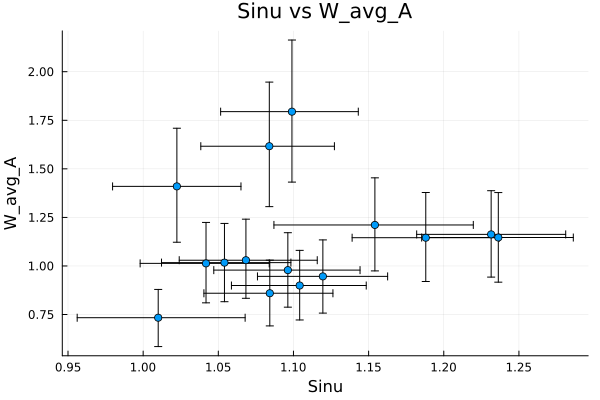

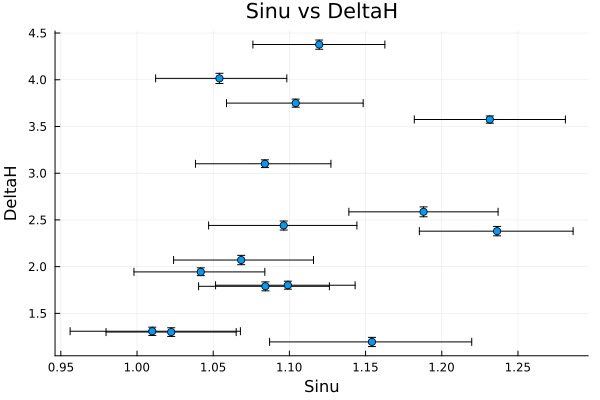

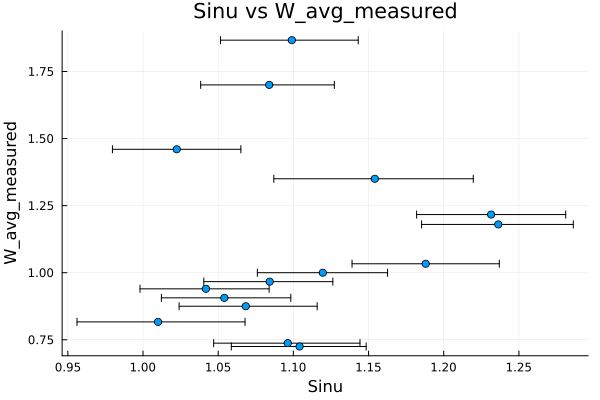

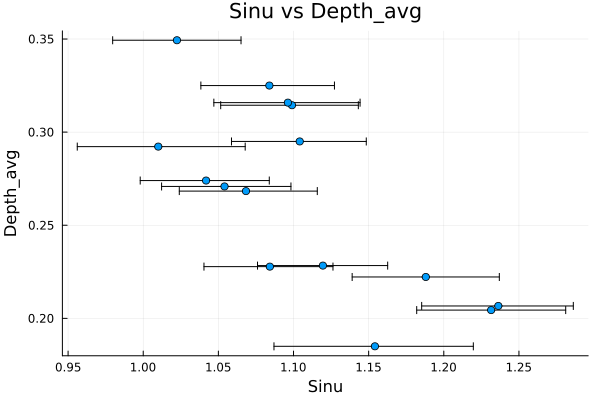

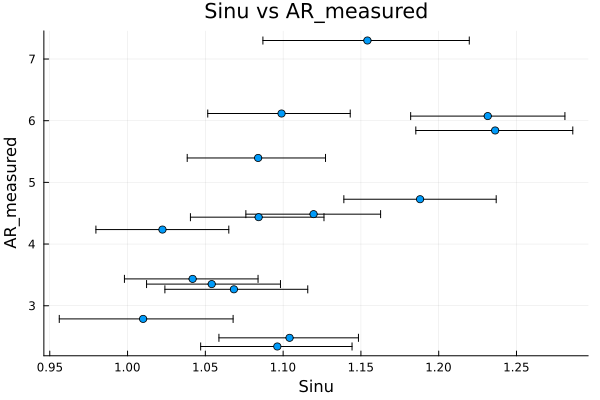

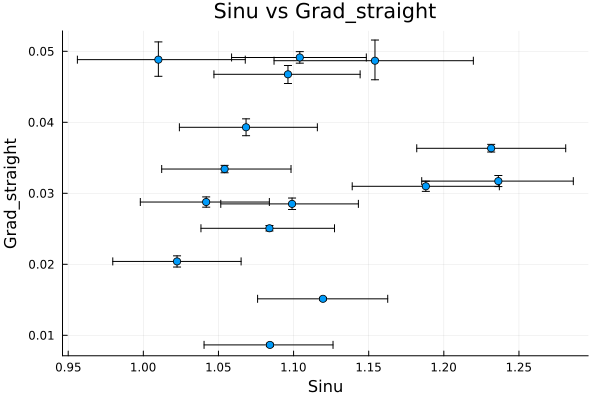

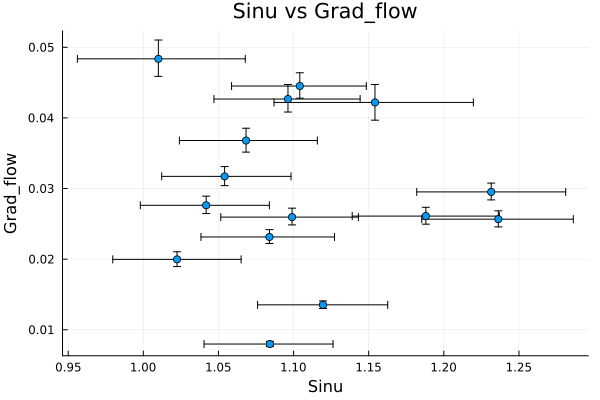

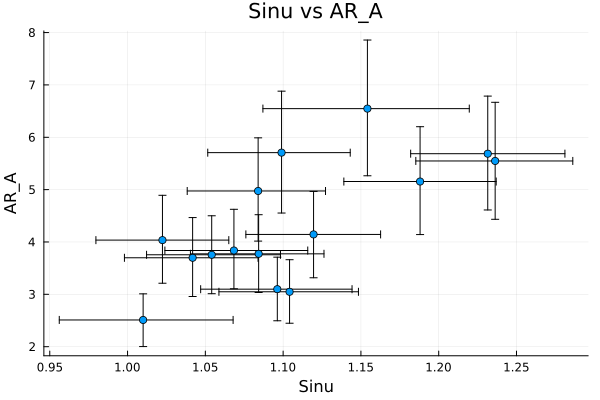

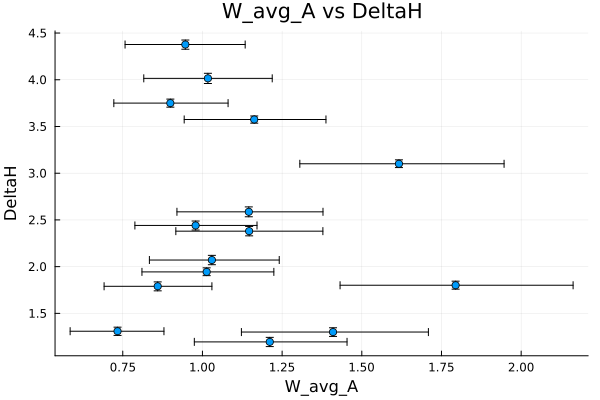

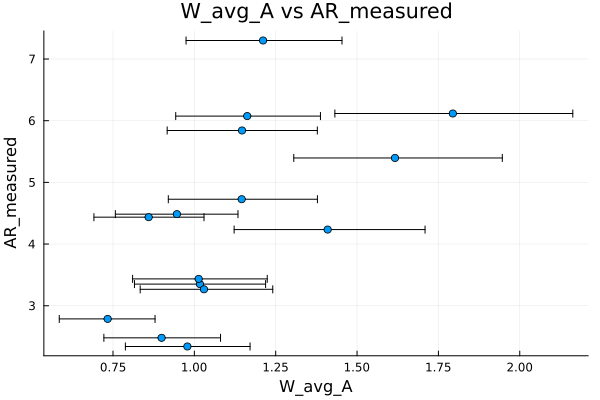

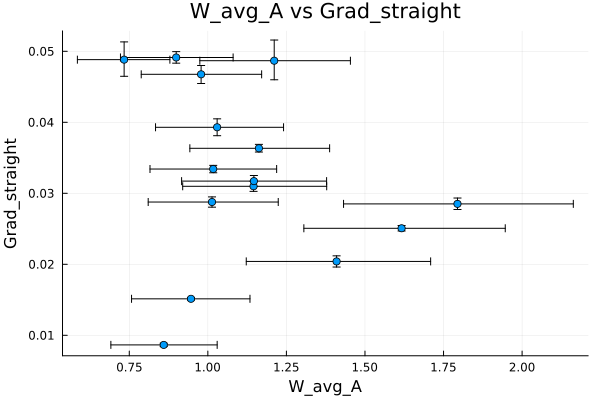

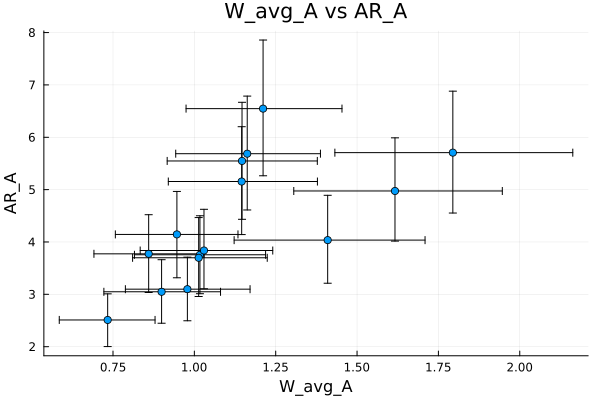

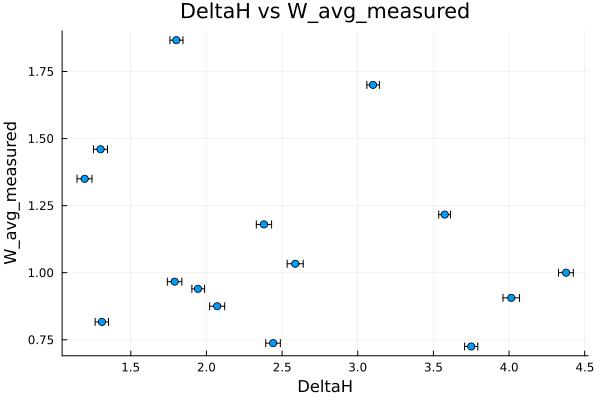

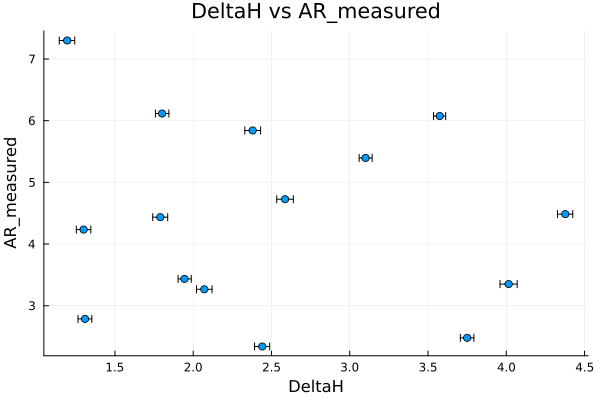

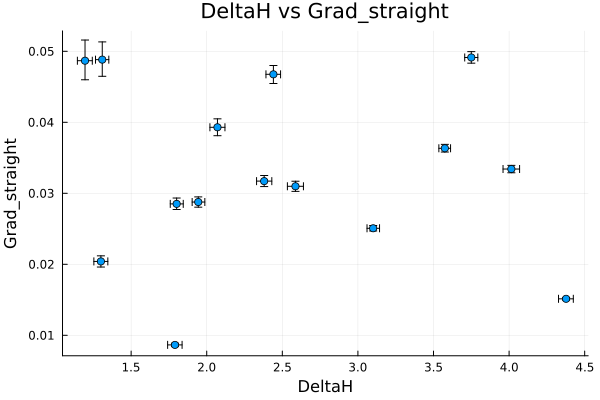

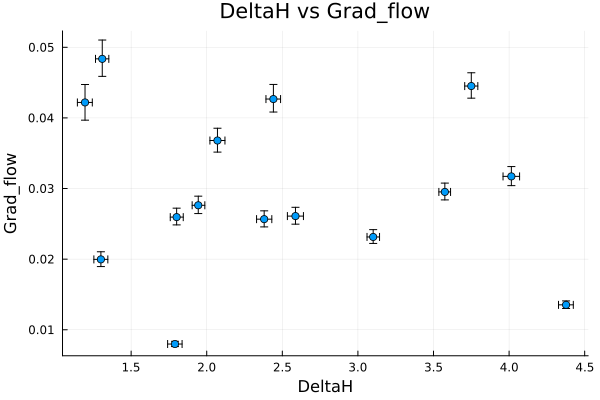

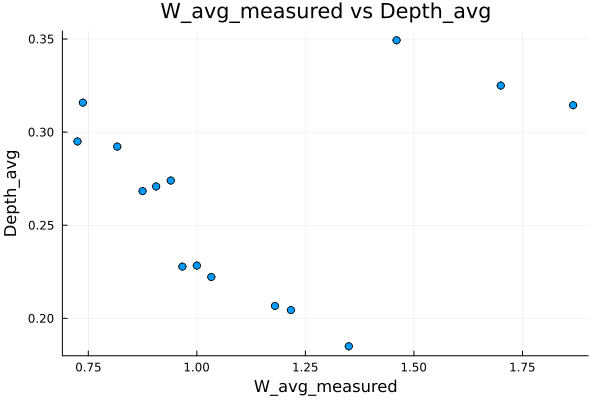

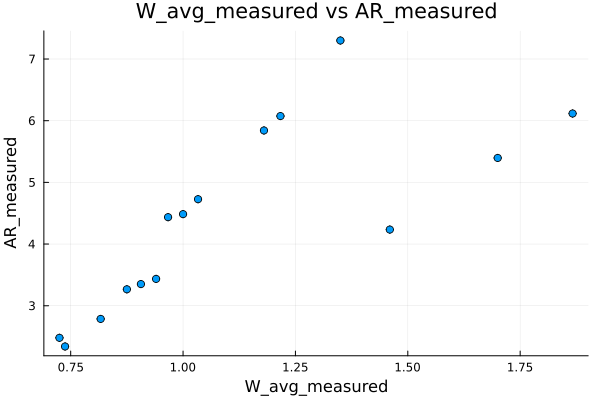

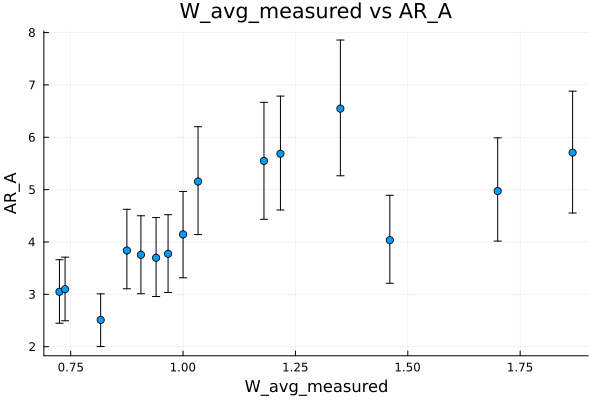

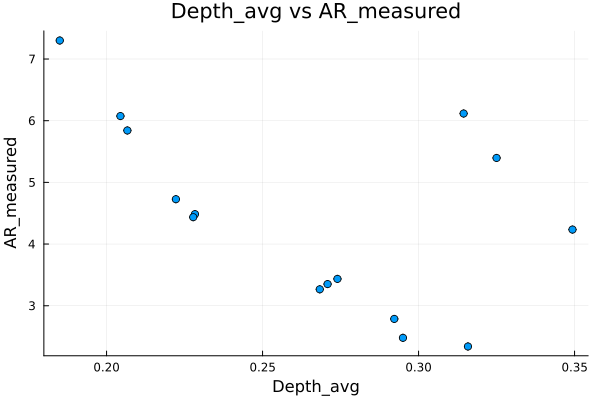

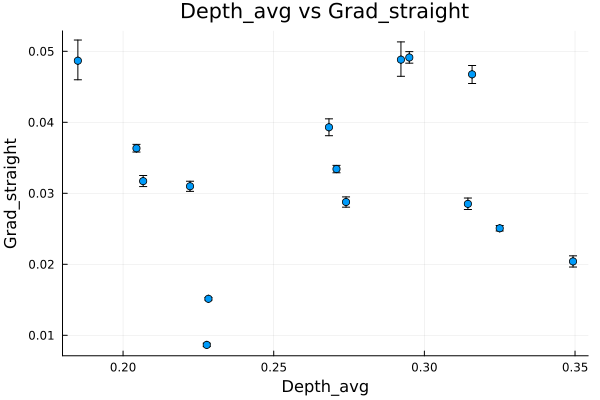

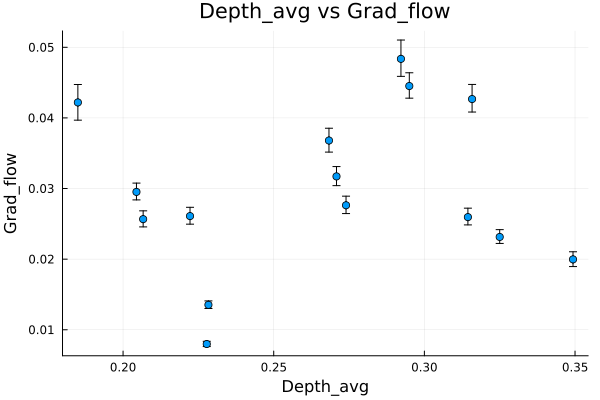

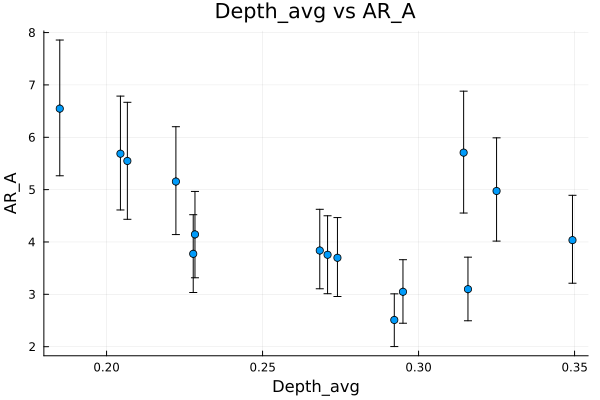

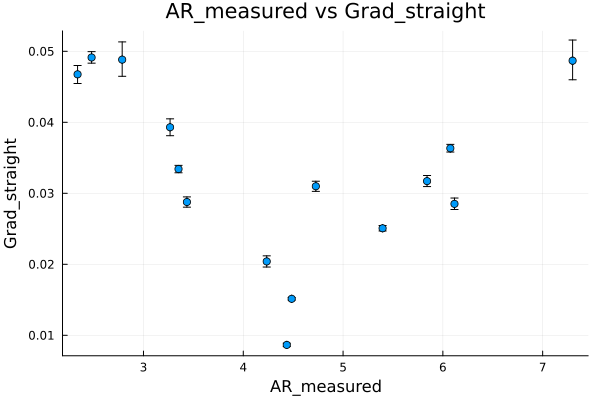

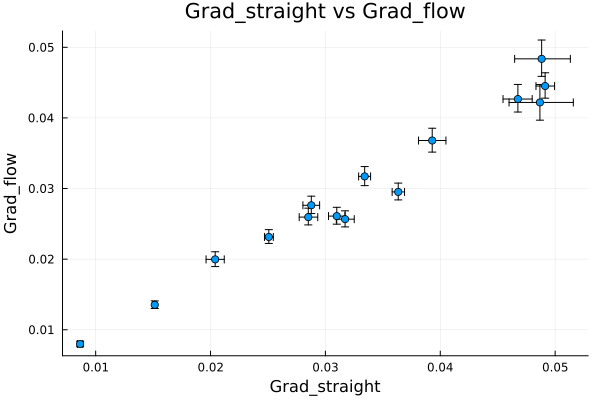

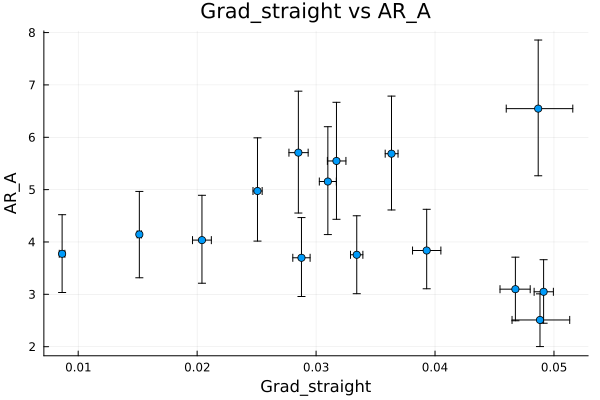

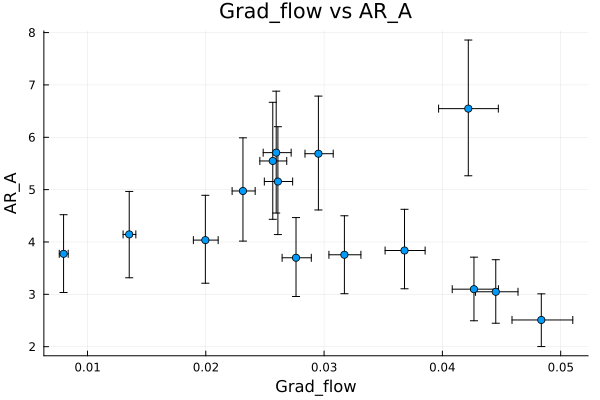

In [18]:
poly_plot = poly[:, [:Sinu, :W_avg_A, :DeltaH, :W_avg_measured, :Depth_avg, :AR_measured, 
                   :Grad_straight, :Grad_flow, :AR_A]]

Makie.inline!(false)
# Get column names
column_names = names(poly_plot)

for i in 1:length(column_names)
    for j in i+1:length(column_names)  # Only plot unique pairs
        x_col = column_names[i]
        y_col = column_names[j]
        
        # Create scatter plot for the pair of variables
        Plots.scatter(poly_plot[!, x_col], poly_plot[!, y_col], 
                xlabel = string(x_col), ylabel = string(y_col), 
                title = string(x_col, " vs ", y_col),
                legend = false)

        # Optionally save each plot or display it
        display(current())  # Shows the plot
        # savefig("scatter_$x_col_$y_col.png")  # To save plots as files
    end
end

In [13]:
# correlation matrix for all variables in poly_plot
poly_plot_m = NamedArray(cor(Matrix(poly_plot)), (names(poly_plot), names(poly_plot)))
cor_matrix = Statistics.cor(poly_plot_m)
#convert to df in order to display
cor_df = DataFrame(cor_matrix, names(poly_plot))
DataFrames.names(cor_df, names(poly_plot))
cor_df = hcat(DataFrame(row_names = names(poly_plot)), cor_df)

9×10 DataFrame
 Row │ row_names       Sinu            W_avg_A         DeltaH          W_avg_m ⋯
     │ String          Particle…       Particle…       Particle…       Particl ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Sinu             1.0             0.0858 ± 0.2    0.261 ± 0.12    0.197  ⋯
   2 │ W_avg_A          0.0858 ± 0.2    1.0            -0.434 ± 0.13    0.967
   3 │ DeltaH           0.261 ± 0.12   -0.434 ± 0.13    1.0            -0.434
   4 │ W_avg_measured   0.197 ± 0.14    0.967 ± 0.023  -0.434 ± 0.048   1.0
   5 │ Depth_avg       -0.949 ± 0.029   0.0644 ± 0.15  -0.263 ± 0.038  -0.0547 ⋯
   6 │ AR_measured      0.703 ± 0.1     0.711 ± 0.09   -0.232 ± 0.047   0.808
   7 │ Grad_straight   -0.25 ± 0.14    -0.745 ± 0.081  -0.145 ± 0.048  -0.783
   8 │ Grad_flow       -0.392 ± 0.13   -0.727 ± 0.085  -0.169 ± 0.051  -0.781
   9 │ AR_A             0.711 ± 0.13    0.711 ± 0.065  -0.211 ± 0.13    0.771  ⋯
                                                               6 columns omitted

## Statistics fun
Linear models

In [14]:
#convert values of poly df to float
poly_temp = poly[:, [:Area, :Perimeter, :MaxDist, :FlowLength, :Sinu, :W_avg_A, :DeltaH, :W_avg_measured, :Depth_avg, :AR_measured, 
                   :Grad_straight, :Grad_flow, :AR_A]] #removes name column
poly_float = DataFrame()
for i in names(poly_temp)
    print("$i")
    poly_float[:, "$i"] = vec(mean(Array(poly_temp[:, "$i"]), dims = 1))
end
poly_float

AreaPerimeterMaxDistFlowLengthSinuW_avg_ADeltaHW_avg_measuredDepth_avgAR_measuredGrad_straightGrad_flowAR_A

15×13 DataFrame
 Row │ Area      Perimeter  MaxDist   FlowLength  Sinu     W_avg_A   DeltaH    ⋯
     │ Float64   Float64    Float64   Float64     Float64  Float64   Float64   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 216.634    270.115   123.679     134.057   1.08393  1.61655     3.101   ⋯
   2 │  91.787    132.282    63.7152     65.1408  1.02243  1.4097      1.3
   3 │ 124.513    140.846    63.1737     69.4229  1.09899  1.79435     1.801
   4 │ 306.183    649.295   289.085     323.647   1.11956  0.94636     4.377
   5 │ 192.854    450.835   206.98      224.418   1.08425  0.85961     1.79    ⋯
   6 │ 113.55     200.351    83.4826     99.1757  1.18803  1.14544     2.587
   7 │ 128.754    255.276   120.142     126.638   1.05409  1.01715     4.015
   8 │  57.945    114.604    52.7038     56.3019  1.06837  1.02958     2.071
   9 │  71.2983   142.785    67.5699     70.3926  1.04182  1.01326     1.944   ⋯
  10 │ 140.781    244.302    98.3774    121.151   1.23152  1.16251     3.575
  11 │  34.3052    58.6728   24.5612     28.3364  1.15417  1.21121     1.195
  12 │ 106.328    187.556    75.049      92.778   1.23629  1.14651     2.38
  13 │  75.765    170.558    76.3337     84.2792  1.10413  0.899333    3.75    ⋯
  14 │  55.9815   116.465    52.2114     57.2325  1.09626  0.978583    2.441
  15 │  19.856     56.1571   26.8196     27.0786  1.01001  0.733612    1.309
                                                               6 columns omitted

In [19]:
colnames = names(poly_float)

for i in 1:length(colnames)
        for j in i+1:length(colnames)  # Only calculate unique pairs, efficient but not nice order
        #for j in 1:length(colnames)  #calculate every pair, inefficient but nice order
        x_col = colnames[j]
        y_col = colnames[i]

         # Create the formula by interpolating column names into a string and converting it to a formula
        formula = @eval @formula($(Symbol(y_col)) ~ $(Symbol(x_col)))
        
        model = lm(formula, poly_float)

        # Print or store the model (Here, we're printing the summary)
        println("\033[1mLinear model between $y_col and $x_col:\033[0m")
        println(model)
        println() 
    end
end

Linear model between Area and Perimeter:
StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Area ~ 1 + Perimeter

Coefficients:
────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error     t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  19.3508    12.668      1.53    0.1506  -8.01679   46.7183
Perimeter     0.453363   0.0486255  9.32    <1e-06   0.348314   0.558412
────────────────────────────────────────────────────────────────────────

Linear model between Area and MaxDist:
StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Area ~ 1 + MaxDist

Coefficients:
───────────────────────────

In [16]:
#tried to have a layout like pairs() in R but did not work
"""
using DataFrames, Plots
#Plots.gr()
poly_plot = poly[:, [:Sinu, :W_avg_A, :DeltaH, :W_avg_measured, :Depth_avg, :AR_measured, 
                   :Grad_straight, :Grad_flow, :AR_A]]

Makie.inline!(false)
# Get column names
column_names = names(poly_plot)
n = length(column_names)  # Number of variables/columns

# Create an n x n layout using Plots
plot_layout = Plots.@layout [grid(n, n)]

# Create an empty plot with the grid layout
p = Plots.plot(layout = plot_layout, legend = false)

# Loop through each pair of variables and create scatter subplots
for i in 1:n
    for j in 1:n
        subplot_idx = (i - 1) * n + j  # Convert (i, j) to linear index
        
        if i != j  # Avoid plotting the same variable against itself
            Plots.scatter!(poly_plot[!, column_names[j]], poly_plot[!, column_names[i]], 
                     xlabel = string(column_names[j]), ylabel = string(column_names[i]),
                     subplot = subplot_idx)  # Plot on the computed index
        else
            # Optionally, you could add a histogram or text label on the diagonal
            Plots.scatter!(zeros(1), zeros(1), subplot = subplot_idx, framestyle = :none)
        end
    end
end

# Display the combined grid plot
display(p)
"""

"using DataFrames, Plots\n#Plots.gr()\npoly_plot = poly[:, [:Sinu, :W_avg_A, :DeltaH, :W_avg_measured, :Depth_avg, :AR_measured, \n                   :Grad_straight, :Grad_flow, :AR_A]]\n\nMakie.inline!(false)\n# Get column names\ncolumn_names = names(poly_plot)\nn = length(colum" ⋯ 701 bytes ⋯ " computed index\n        else\n            # Optionally, you could add a histogram or text label on the diagonal\n            Plots.scatter!(zeros(1), zeros(1), subplot = subplot_idx, framestyle = :none)\n        end\n    end\nend\n\n# Display the combined grid plot\ndisplay(p)\n"